<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-и-подготовка-данных" data-toc-modified-id="Изучение-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение и подготовка данных</a></span></li><li><span><a href="#Часть-1.-Приоритизация-гипотез." data-toc-modified-id="Часть-1.-Приоритизация-гипотез.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Часть 1. Приоритизация гипотез.</a></span></li><li><span><a href="#Часть-2.-Анализ-А/В-теста." data-toc-modified-id="Часть-2.-Анализ-А/В-теста.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Часть 2. Анализ А/В-теста.</a></span></li><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод.</a></span></li></ul></div>

# Результаты А/В-тестирования

Цель проекта: приоритизация гипотез по увеличению выручки, запуск A/B-теста и анализ результатов.

## Изучение и подготовка данных 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import math as mth
import warnings
warnings.filterwarnings("ignore")

server_path_hypothesis = '/datasets/hypothesis.csv'
server_path_orders = '/datasets/orders.csv'
server_path_visitors = '/datasets/visitors.csv'

filename_hypothesis = 'hypothesis.csv'
filename_orders = 'orders.csv'
filename_visitors = 'visitors.csv'

try: 
    hypothesis = pd.read_csv(server_path_hypothesis, sep=',')
    orders = pd.read_csv(server_path_orders, sep=',')
    visitors = pd.read_csv(server_path_visitors, sep=',')
except: 
    hypothesis = pd.read_csv(filename_hypothesis, sep=',')
    orders = pd.read_csv(filename_orders, sep=',')
    visitors = pd.read_csv(filename_visitors, sep=',') 

In [2]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [3]:
hypothesis.columns = hypothesis.columns.str.lower()

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
orders['date'] = pd.to_datetime(orders['date']) 

In [8]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [10]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [11]:
orders.duplicated().sum()

0

In [12]:
visitors.duplicated().sum()

0

Дубликаты и пропуски отсутствуют. Типы данных корректны. Для корректности исследования посмотрим, есть ли пользователи, попавшие в обе группы.  

In [13]:
users_duplicated = orders.groupby('visitorId')['group'].nunique().reset_index()
users_duplicated.head()

,visitorId,group
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


In [14]:
flickers = users_duplicated.query('group == 2')
flickers.shape

(58, 2)

Есть 58 человек, которые попали в обе группы. Удалим их из датасета.

In [15]:
users_by_group = orders.groupby(['visitorId', 'group'], as_index=False)['revenue'].sum()
orders_new = users_by_group.drop_duplicates(subset='visitorId', keep=False)
users_clean = pd.Series(orders_new['visitorId'])
users_clean

0          5114589
1          6958315
4         11685486
5         39475350
6         47206413
           ...    
1082    4259830713
1085    4278982564
1086    4279090005
1087    4281247801
1088    4283872382
Name: visitorId, Length: 973, dtype: int64

Мы оставили объект Series с теми пользователями, чьи ID не повторяются в группировке по группам. Обрежем датасет orders так, чтобы ID пользователей соответствовал оставшимся. 

In [16]:
orders = orders.query('visitorId in @users_clean')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [17]:
users_duplicated_2 = orders.groupby('visitorId')['group'].nunique().reset_index()
flickers_2 = users_duplicated_2.query('group == 2')
flickers_2.shape[0]

0

Пользователей, оказавшихся в обеих группах исследования больше нет. Данные готовы к анализу. 

## Часть 1. Приоритизация гипотез.

Задачи: 
- Применить фреймворк ICE для приоритизации гипотез; 
- Применить фреймворк RICE для приоритизации гипотез, где: 

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Reach * Impact * Confidence}{Efforts}$$

In [18]:
pd.options.display.max_colwidth = 110

In [19]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis['ICE'] = pd.to_numeric(hypothesis['ICE'].map('{:.1f}'.format))
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Приоритизация гипотез с помощью фреймворка ICE, где потенциальное влияние изменений, помноженное на уверенность в результате, делятся на прилагаемые усилия, в качестве наиболее перспективных гипотез указывает на 8 - запуск акции, 0 - увеличение каналов привлечения трафика, 7 - добавление опции оформления подписки, 6 - установка баннера с актуальными предложениями.  

In [20]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Добавление категории Reach в фреймворк показывает, что охваты в расчете некоторых гипотез обладают довольно высоким коэффициентом влияния. Исходя из данного метода приоритизации, самыми перспективными гипотезами являются 7 - офомление подписки (без учета категории reach коэффициент 11,2 против 112 с учетом охватов - reach по 10-балльной шкале максимальный), 2 - добавление блоков рекомендаций (охваты меняют коэффициент с 7 до 56), 0 - новые каналы привлечения, 6 - баннер с актуальными предложениями. 

In [21]:
hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(
    by='ICE', ascending=False).style.background_gradient(cmap='Blues', axis=None, low=0)

,hypothesis,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.300000,40.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.300000,4.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.100000,9.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


***Вывод***

Потенциально успешными гипотезами, учитывая анализ фреймворков ICE и RICE, можно назвать 0, 2, 6 и 7. Гипотеза 8 показывает малые значения охватов, будучи на первом месте по ICE: показатель Reach не изменил итоговый коэффициент. 

## Часть 2. Анализ А/В-теста.

Сформулируем общие гипотезы. 

- **Нулевая гипотеза: результаты группы А и группы В по конверсии и среднему чеку равны**
- **Альтернативная гипотеза: результаты группы А и группы В по конверсии и среднему чеку различаются**

Для анализа результатов тестирования и построения графиков нужно собрать кумулятивные данные. 

In [22]:
dates_groups = orders[['date', 'group']].drop_duplicates()

In [23]:
orders_aggregated = dates_groups.apply(lambda x: orders[
    np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
    {'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis=1).sort_values(
    by=['date', 'group'])
orders_aggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [24]:
visitors_aggregated = dates_groups.apply(lambda x: visitors[
    np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
    {'date':'max', 'group':'max', 'visitors':'sum'}), axis=1).sort_values(
    by=['date', 'group'])
visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [25]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'transactions', 'buyers', 'revenue', 'visitors']
cumulative_data.head()

,date,group,transactions,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Посчитаем кумулятивную выручку по группам и построим графики.

In [26]:
cumulative_revenue_A = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'transactions']]
cumulative_revenue_A.head()

,date,revenue,transactions
0,2019-08-01,142779,23
2,2019-08-02,234381,42
4,2019-08-03,346854,66
6,2019-08-04,388030,77
8,2019-08-05,474413,99


In [27]:
cumulative_revenue_B = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'transactions']]
cumulative_revenue_B.head()

,date,revenue,transactions
1,2019-08-01,59758,17
3,2019-08-02,221801,40
5,2019-08-03,288850,54
7,2019-08-04,385740,68
9,2019-08-05,475648,89


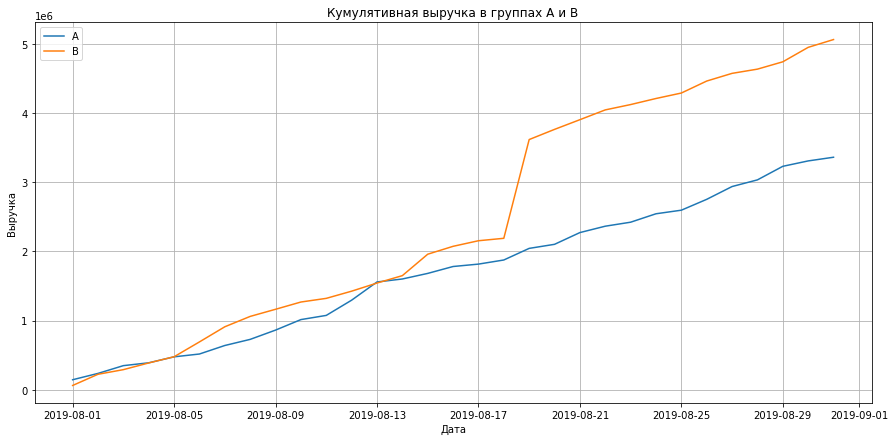

In [28]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')
ax.set_title('Кумулятивная выручка в группах А и В')
ax.set_xlabel('Дата')
ax.set_ylabel('Выручка')
ax.grid()
plt.legend()
plt.show()

Обе линии растут со временем. В середине графика выручка группы В резко превышает значения группы А. 18 августа кумулятивная выручка группы В меняет значение с 2,7 млн. до 4,1 млн., затем растет параллельно графику группы А. Вероятно, это связано с особо крупным заказом в эту дату. 

Теперь построим график кумулятивного среднего чека по группам.

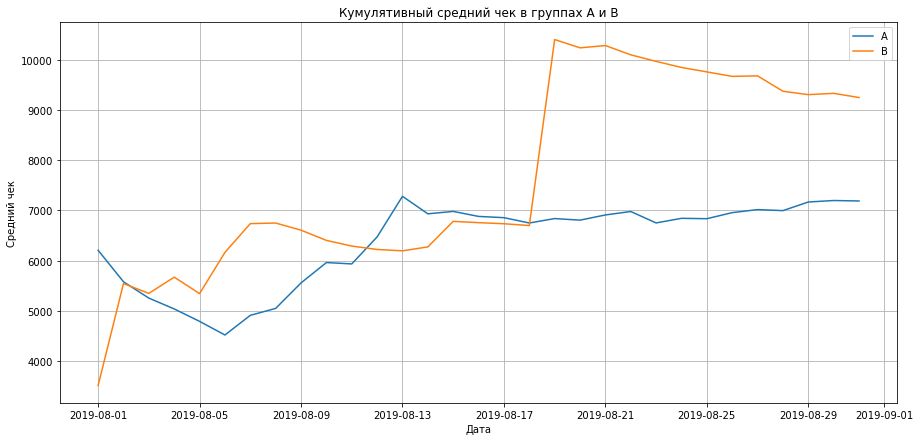

In [29]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['transactions'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['transactions'], label='B')
ax.set_title('Кумулятивный средний чек в группах А и В')
ax.set_xlabel('Дата')
ax.set_ylabel('Средний чек')
ax.grid()
plt.legend()
plt.show()

Графики среднего чека менее статичны. Линия группы А растет до 13 августа, затем практически выравнивается около значения в 7 тысяч. График группы В 18 августа резко поднимается вверх, затем немного спадает. Разница между значениями более 3 тысяч. Это подтверждает тезис о том, что необходимо очистить группы от выбросов. 

Следующий шаг - расчет относительного изменения кумулятивного среднего чека группы В к группе А. 

In [30]:
merged_cumulative_revenue = cumulative_revenue_A.merge(
    cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
merged_cumulative_revenue.head()

,date,revenueA,transactionsA,revenueB,transactionsB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


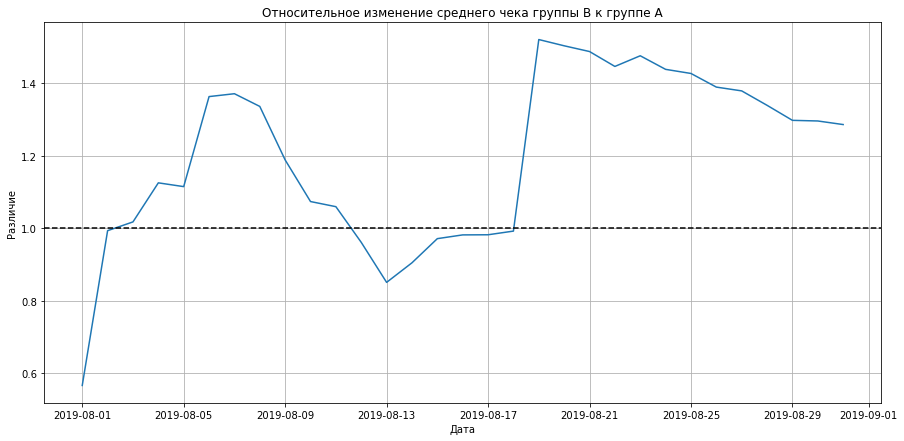

In [31]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['transactionsB'])/(
    merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['transactionsA']))
ax.set_title('Относительное изменение среднего чека группы В к группе А')
ax.set_xlabel('Дата')
ax.set_ylabel('Различие')
ax.grid()
plt.axhline(y=1, color='black', linestyle='--') 
plt.show()

Средний чек группы В сильно выше среднего чека группы А. График динамичный, минимальное значение находится у отметки в 0,6, максимальное - 1,5. В некоторые даты наблюдаются особо крупная разница в значениях.

Далее посчитаем кумулятивную конверсию.

In [32]:
cumulative_data['conversion'] = cumulative_data['transactions'] / cumulative_data['visitors']
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']

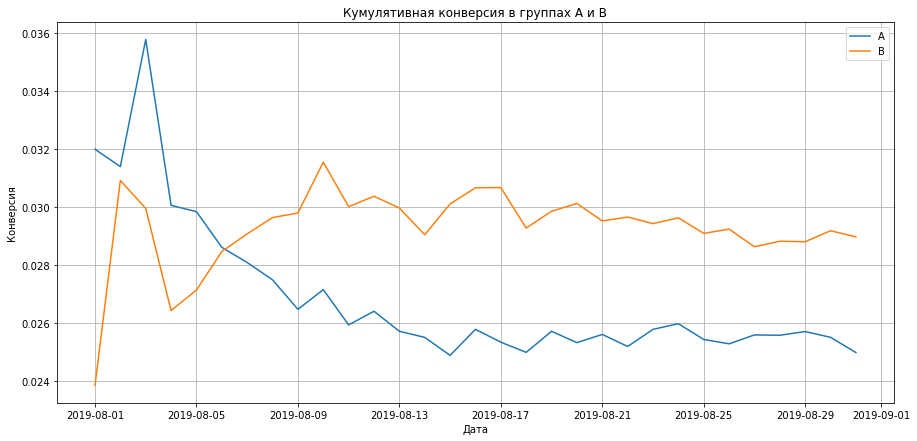

In [33]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
ax.set_title('Кумулятивная конверсия в группах А и В')
ax.set_xlabel('Дата')
ax.set_ylabel('Конверсия')
ax.grid()
plt.legend()
plt.show()

В начале теста конверсия группы А значительно превышала конверсию группы В, однако, 6 августа графики пересекаются и кумулятивная конверсия группы В становится выше, но постепенно идет на спад к значениям около 0,029, в то время как конверсия А колеблется около 0,025.  

Также построим график относительного изменения кумулятивной конверсии группы В к группе А. 

In [34]:
merged_cumulative_conversion = cumulative_data_A[['date', 'conversion']].merge(
    cumulative_data_B[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
merged_cumulative_conversion.head()

,date,conversionA,conversionB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


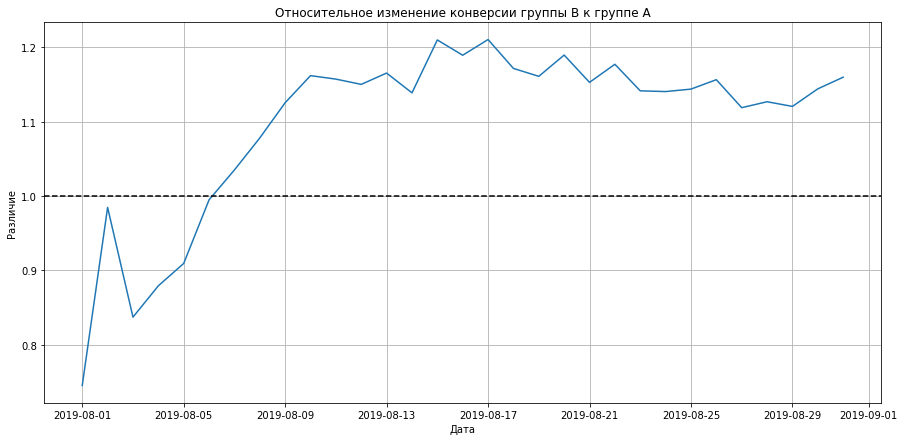

In [35]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(merged_cumulative_conversion['date'], merged_cumulative_conversion['conversionB']/merged_cumulative_conversion['conversionA'])
ax.set_title('Относительное изменение конверсии группы В к группе А')
ax.set_xlabel('Дата')
ax.set_ylabel('Различие')
ax.grid()
plt.axhline(y=1, color='black', linestyle='--') 
plt.show()

График относительного изменения конверсии также показывает резкое превалирование значений конверсии в группе В, которая растет с 3 по 10 августа, затем разница колеблется около коэффициента 1.15.

Теперь посмотрим на количество заказов на пользователя. 

In [36]:
orders_per_user = orders.drop(['date', 'revenue', 'group'], axis=1).groupby(
    'visitorId', as_index=False).agg({'transactionId':'nunique'})
orders_per_user.columns = ['users', 'orders'] 

In [37]:
x_values_users = pd.Series(range(0, len(orders_per_user)))

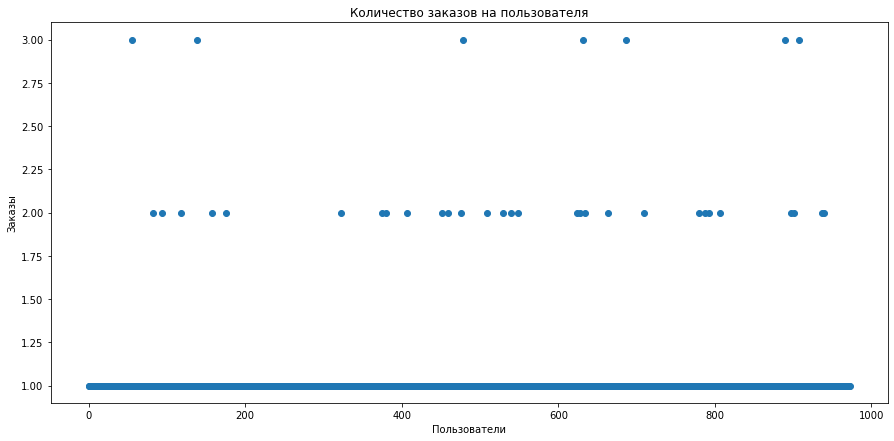

In [38]:
fig, ax=plt.subplots(figsize=(15, 7))
plt.scatter(x_values_users, orders_per_user['orders'])
ax.set_title('Количество заказов на пользователя')
ax.set_xlabel('Пользователи')
ax.set_ylabel('Заказы')
plt.show()

Большинство пользователей совершает 1 заказ. Намного меньше тех, кто делает два заказа. Очевидные выбросы - пользователи, совершившие 3 заказа, их всего 7. Чтобы выбрать границу для определения аномалий, посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [39]:
np.percentile(orders_per_user['orders'], [95, 99])

array([1., 2.])

95% пользовалей совершает 1 заказ. Не более 1% покупателей делает более 2 заказов. 

Теперь посмотрим на точечное распределение стоимости заказа.

In [40]:
x_values_revenue = pd.Series(range(0, len(orders['revenue'])))

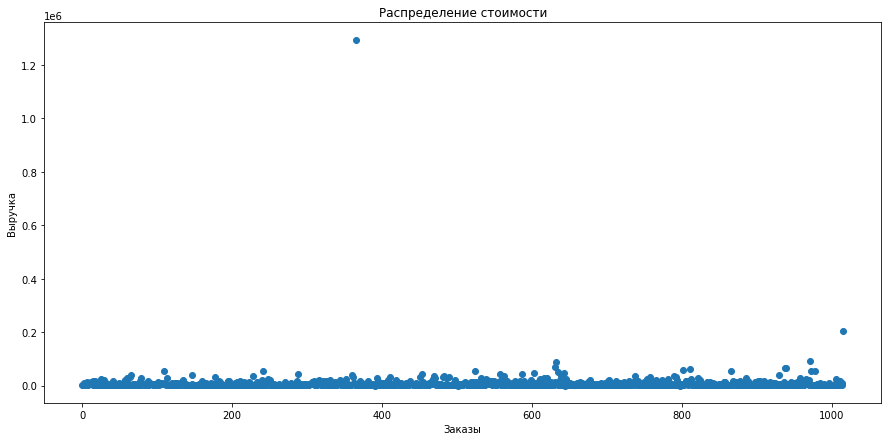

In [41]:
fig, ax=plt.subplots(figsize=(15, 7))
plt.scatter(x_values_revenue, orders['revenue'])
ax.set_title('Распределение стоимости')
ax.set_xlabel('Заказы')
ax.set_ylabel('Выручка')
plt.show()

In [42]:
orders['revenue'].describe()

count    1.016000e+03
mean     8.300815e+03
std      4.212199e+04
min      5.000000e+01
25%      1.190000e+03
50%      2.955000e+03
75%      8.134250e+03
max      1.294500e+06
Name: revenue, dtype: float64

В среднем, стоимость заказов не превышает отметку в 30 тысяч. Наблюдается один пользователь, совершивший покупку на более чем 1,2 млн. и один пользователь, стоимость покупки которого более 200 тысяч. Выбросы очевидны. Предыдущие графики среднего чека принимают более понятное объяснение. Посчитаем статистические аномалии. 

In [43]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% покупателей делают заказы стоимостью выше 26,8 тысяч. Не более 1% - выше 53,9 тысячи.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным - без удаления аномальных пользователей.  

In [44]:
orders_A_daily = orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']].groupby(
    'date', as_index=False).agg({'transactionId':'nunique', 'revenue':'sum'})
orders_A_daily.columns = ['date', 'order_per_date_A', 'revenue_per_date_A']
orders_A_cumulative = orders_A_daily.apply(lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
    {'date':'max', 'order_per_date_A':'sum', 'revenue_per_date_A':'sum'}), axis=1).sort_values(by=['date'])
orders_A_cumulative.columns = ['date', 'orders_cumulative_A', 'revenue_cumulative_A']
orders_A_cumulative.head()

,date,orders_cumulative_A,revenue_cumulative_A
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413


In [45]:
orders_B_daily = orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']].groupby(
    'date', as_index=False).agg({'transactionId':'nunique', 'revenue':'sum'})
orders_B_daily.columns = ['date', 'order_per_date_B', 'revenue_per_date_B']
orders_B_cumulative = orders_B_daily.apply(lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
    {'date':'max', 'order_per_date_B':'sum', 'revenue_per_date_B':'sum'}), axis=1).sort_values(by=['date'])
orders_B_cumulative.columns = ['date', 'orders_cumulative_B', 'revenue_cumulative_B']
orders_B_cumulative.head()

,date,orders_cumulative_B,revenue_cumulative_B
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648


In [46]:
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']
visitors_A_cumulative = visitors_A_daily.apply(lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
    {'date':'max', 'visitors_per_date_A':'sum'}), axis=1).sort_values(by=['date'])
visitors_A_cumulative.columns = ['date', 'visitors_cumulative_A']
visitors_A_cumulative.head()

,date,visitors_cumulative_A
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [47]:
visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']
visitors_B_cumulative = visitors_B_daily.apply(lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
    {'date':'max', 'visitors_per_date_B':'sum'}), axis=1).sort_values(by=['date'])
visitors_B_cumulative.columns = ['date', 'visitors_cumulative_B']
visitors_B_cumulative.head()

,date,visitors_cumulative_B
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [48]:
total_data = orders_A_daily.merge(orders_B_daily, left_on='date', right_on='date', how='left').merge(
    orders_A_cumulative, left_on='date', right_on='date', how='left').merge(
    orders_B_cumulative, left_on='date', right_on='date', how='left').merge(
    visitors_A_daily, left_on='date', right_on='date', how='left').merge(
    visitors_B_daily, left_on='date', right_on='date', how='left').merge(
    visitors_A_cumulative, left_on='date', right_on='date', how='left').merge(
    visitors_B_cumulative, left_on='date', right_on='date', how='left')
total_data.head()

,date,order_per_date_A,revenue_per_date_A,order_per_date_B,revenue_per_date_B,orders_cumulative_A,revenue_cumulative_A,orders_cumulative_B,revenue_cumulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cumulative_A,visitors_cumulative_B
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [49]:
orders_per_user_A = orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
orders_per_user_A.columns = ['visitorId', 'orders']

In [50]:
orders_per_user_B = orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
orders_per_user_B.columns = ['visitorId', 'orders']

In [51]:
sample_A = pd.concat([orders_per_user_A['orders'], pd.Series(0, index = np.arange(
    total_data['visitors_per_date_A'].sum() - len(orders_per_user_A['orders'])), name='orders')], axis=0)

In [52]:
sample_B = pd.concat([orders_per_user_B['orders'], pd.Series(0, index = np.arange(
    total_data['visitors_per_date_B'].sum() - len(orders_per_user_B['orders'])), name='orders')], axis=0)

Теперь с помощью теста, основанного на непараметрическом подходе Манна-Уитни, посчитаем p-value и относительный прирост конверсии группы В. 

*Н₀ - конверсии тестируемых групп равны.*

*Н₁ - конверсия группы В больше конверсии группы А.*

In [53]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(sample_A, sample_B)[1]))

P-value: 0.006


In [54]:
print('Относительные различия конверсий по сырым данным: {0:.3f}'.format(sample_B.mean() / sample_A.mean() - 1))

Относительные различия конверсий по сырым данным: 0.160


P-value меньше 0,05, значит нулевую гипотезу о том, что статистических различий в выборках нет, мы отвергаем. Однако мы можем совершить ошибку первого рода, когда p-value меньше, но разницы между группами нет. Относительная конверсия группы В на 15% больше группы А. Посмотрим на различия в среднем чеке. 

*Н₀ - средние чеки тестируемых групп равны.*

*Н₁ - средний чек группы В больше среднего чека группы А.*

In [55]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))

P-value: 0.415


In [56]:
print('Относительные различия средних чеков по сырым данным: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean() - 1))

Относительные различия средних чеков по сырым данным: 0.287


P-value значительно больше 0,05, однако разница между средним чеком группы В и группы А довольно высока - 28,7%. Здесь ситуация наоборот. С учетом выбросом есть вероятность совершить ошибку второго рода и принять нулевую гипотезу о равенстве групп ложно. Очистим данные согласно расчетам статистических аномалий, где количество заказов больше двух и средний чек больше 26,8 тысяч.

In [57]:
users_with_many_orders = pd.concat([orders_per_user_A[orders_per_user_A['orders'] > 1]['visitorId'], 
                                    orders_per_user_B[orders_per_user_B['orders'] > 1]['visitorId']], axis=0)

In [58]:
users_with_expensive_orders = orders[orders['revenue'] > 26800]['visitorId']

In [59]:
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0).drop_duplicates().sort_values()
abnormal_users.shape[0]

86

86 аномальных пользователя. Подготовим очищенные выборки. 

In [60]:
sample_A_filtered = pd.concat([orders_per_user_A[np.logical_not(
    orders_per_user_A['visitorId'].isin(abnormal_users))]['orders'], pd.Series(
    0, index=np.arange(total_data['visitors_per_date_A'].sum() - len(orders_per_user_A['orders'])), name='orders')], axis=0) 

In [61]:
sample_B_filtered = pd.concat([orders_per_user_B[np.logical_not(
    orders_per_user_B['visitorId'].isin(abnormal_users))]['orders'], pd.Series(
    0, index=np.arange(total_data['visitors_per_date_B'].sum() - len(orders_per_user_B['orders'])), name='orders')], axis=0) 

*Н₀ - конверсии тестируемых групп равны.*

*Н₁ - конверсия группы В больше конверсии группы А.*

In [62]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))

P-value: 0.008


In [63]:
print('Относительные различия конверсий: {0:.3f}'.format(sample_B_filtered.mean() / sample_A_filtered.mean()-1))

Относительные различия конверсий: 0.174


P-value меньше 0,05, наличие различия статистически подтверждаются. Отношение конверсии группы В к группе А по данным без аномалий составляет 17,4%. *Тест показывает, что группы А и В отличаются по конверсии, то есть группа В чаще совершает покупки по сравнению с группой А.* Посчитаем относительные различия по среднему чеку.

*Н₀ - средние чеки тестируемых групп равны.*

*Н₁ - средний чек группы В больше среднего чека группы А.*

In [64]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(
    orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'],
    orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'])[1]))

P-value: 0.364


In [65]:
print('Относительные различия средних чеков: {0:.3f}'.format(
    orders[np.logical_and(orders['group'] == 'B', np.logical_not(
    orders['visitorId'].isin(abnormal_users)))]['revenue'].mean() / 
    orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean() - 1))

Относительные различия средних чеков: -0.034


P-value по-прежнему сильно больше статистической значимости, значит, мы можем принять нулевую гипотезу. Однако, отношение выборок радикально изменилось. Без аномальных значений средний чек группы В ниже среднего чека группы А на 3,4%. *Таким образом, средний чек группы В немного меньше среднего чека группы А, но, в целом, группы равны.*

## Вывод. 

Тест можно считать завершенным. Группа В показывает более высокие результаты по конверсии, тем не менее, средний чек остается на том же уровне, что и у группы А. Изменения не влияют на увеличение выручки. 